In [12]:
import cv2
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import LSTM, Dense, Dropout, BatchNormalization

In [2]:
from google.colab import files

uploaded = files.upload()

Saving dataset.zip to dataset.zip


In [3]:
import zipfile
import io
zf = zipfile.ZipFile(io.BytesIO(uploaded['dataset.zip']), "r")
zf.extractall()

In [4]:
file_path = '../content/dataset'
data_dir = pathlib.Path(file_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Mild_Demented' 'Moderate_Demented' 'Normal' 'Tumor' 'Tumor_mild'
 'Tumor_verymild' 'Very_Mild_Demented']


In [5]:
def apply_filters(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.convertScaleAbs(img)
    img_pnlm = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    img_eq = cv2.equalizeHist(img_pnlm[:,:,0])
    img_out = np.stack([img_eq, img_eq, img_eq], axis=-1)  # Add channel dimension
    return img_out

In [8]:
img_width, img_height = 224, 224
seq_length = 16

# Load Efficientnet model without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Define function to extract features from image using VGG16 model
def extract_features(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))
    img = np.array(img)
    x = apply_filters(img)
    x = preprocess_input(x)
    features = base_model.predict(np.array([x]))
    return features

16705208/16705208 [==============================] - 1s 0us/step


In [9]:
def preprocess_data(data_dir, img_size=(224, 224)):
  
    # Initialize empty lists to store the features and labels
    train_features = []
    train_labels = []
    val_features = []
    val_labels = []

    # Loop over each class folder
    for i, class_name in enumerate(sorted(os.listdir(data_dir))):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        print(f"Processing class {class_name} ({i+1}/{len(os.listdir(data_dir))})")
        # Initialize empty lists to store the features and labels for this class
        class_train_features = []
        class_train_labels = []
        class_val_features = []
        class_val_labels = []

        # Loop over each image in the class folder
        for image_name in sorted(os.listdir(class_dir)):
            if not image_name.endswith(".jpg"):
                continue
            image_path = os.path.join(class_dir, image_name)
            # Extract the features from the image using the VGG16 model
            features = extract_features(image_path)
            # Append the features and label to the appropriate list
            if len(class_train_features) < 0.8 * (len(class_train_features) + len(class_val_features)):
                class_train_features.append(features)
                class_train_labels.append(i)
            else:
                class_val_features.append(features)
                class_val_labels.append(i)

        # Convert the lists to numpy arrays and append them to the main lists
        train_features.extend(class_train_features)
        train_labels.extend(class_train_labels)
        val_features.extend(class_val_features)
        val_labels.extend(class_val_labels)

    # Convert the lists to numpy arrays and shuffle the training data
    train_features = np.array(train_features)
    train_labels = np.array(train_labels)
    val_features = np.array(val_features)
    val_labels = np.array(val_labels)
    idx = np.random.permutation(len(train_features))
    train_features = train_features[idx]
    train_labels = train_labels[idx]

    train_labels = to_categorical(train_labels, num_classes=7)
    val_labels = to_categorical(val_labels, num_classes=7)
    return train_features, train_labels, val_features, val_labels

In [10]:
train_features, train_labels, val_features, val_labels = preprocess_data(file_path)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 85ms/step
Processing class Moderate_Demented (2/7)
1/1 [==============================] - 0s 83ms/step
Processing class Normal (3/7)
1/1 [==============================] - 0s 86ms/step
Processing class Tumor (4/7)
1/1 [==============================] - 0s 87ms/step
Processing class Tumor_mild (5/7)
1/1 [==============================] - 0s 89ms/step
Processing class Tumor_verymild (6/7)
1/1 [==============================] - 0s 87ms/step
Processing class Very_Mild_Demented (7/7)
1/1 [==============================] - 0s 101ms/step


In [15]:
train_features = np.reshape(train_features, (train_features.shape[0], 16, -1))
val_features = np.reshape(val_features, (val_features.shape[0], 16, -1))

In [20]:
# Define model architecture
model = Sequential()
model.add(BatchNormalization(input_shape=(seq_length, 3920)))
model.add(LSTM(128,activation='tanh',return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(64))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(7, activation='softmax'))

# Compile model
model.compile(optimizer='Adamax', loss=tf.keras.losses.KLDivergence(), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 16, 3920)         15680     
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 16, 128)           2073088   
                                                                 
 dropout_3 (Dropout)         (None, 16, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 64)               

In [21]:
checkpoint = ModelCheckpoint('weights_epoch{epoch:02d}.h5', save_weights_only=True)

history = model.fit(train_features, train_labels, epochs=50, batch_size=16, validation_data=(val_features, val_labels),callbacks=[checkpoint])

Epoch 1/50
257/257 [==============================] - 63s 225ms/step - loss: 1.3606 - accuracy: 0.4822 - val_loss: 0.7561 - val_accuracy: 0.7136
Epoch 2/50
257/257 [==============================] - 57s 222ms/step - loss: 0.9242 - accuracy: 0.6390 - val_loss: 0.5888 - val_accuracy: 0.7320
Epoch 3/50
257/257 [==============================] - 59s 229ms/step - loss: 0.7623 - accuracy: 0.6926 - val_loss: 0.5225 - val_accuracy: 0.7825
Epoch 4/50
257/257 [==============================] - 59s 230ms/step - loss: 0.6592 - accuracy: 0.7303 - val_loss: 0.5309 - val_accuracy: 0.7631
Epoch 5/50
257/257 [==============================] - 58s 226ms/step - loss: 0.5884 - accuracy: 0.7717 - val_loss: 0.4628 - val_accuracy: 0.8223
Epoch 6/50
257/257 [==============================] - 58s 224ms/step - loss: 0.4802 - accuracy: 0.8169 - val_loss: 0.4535 - val_accuracy: 0.8204
Epoch 7/50
257/257 [==============================] - 58s 224ms/step - loss: 0.4134 - accuracy: 0.8522 - val_loss: 0.4346 - val_ac

In [24]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

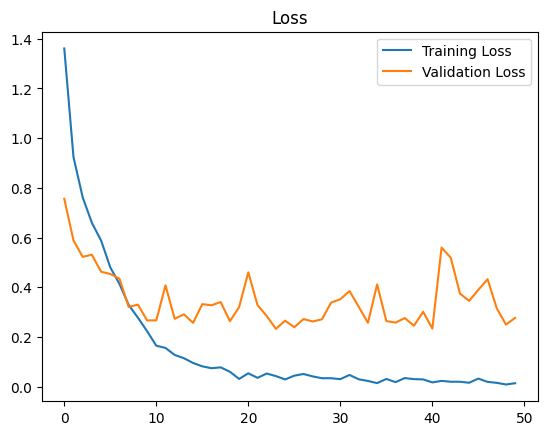

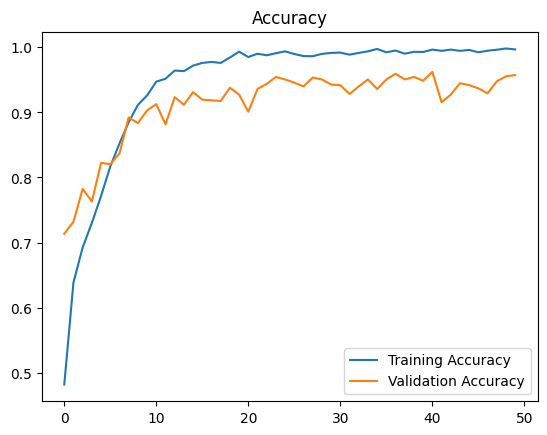

In [25]:
plot_metrics(history.history) 

In [26]:
model.load_weights('weights_epoch{}.h5'.format(41))

model_evaluate = model.evaluate(val_features,val_labels)
print("Accuracy: %", "{:.2f}".format(model_evaluate[1]*100))
print("Loss: %", "{:.2f}".format(model_evaluate[0]*100))

33/33 [==============================] - 3s 76ms/step - loss: 0.2339 - accuracy: 0.9621
Accuracy: % 96.21
Loss: % 23.39


In [28]:
# Use the model to make predictions on the test data
y_pred = model.predict(val_features)

# Convert the predicted probabilities to predicted labels
y_pred = np.argmax(y_pred, axis=1)
val_labels = np.argmax(val_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(val_labels, y_pred)

print(cm)

33/33 [==============================] - 4s 86ms/step
[[135   0   3   0   0   0   2]
 [  0  13   0   0   0   0   0]
 [  0   0 233   0   0   0   7]
 [  0   0   0 187   2   0   0]
 [  0   0   0   3 219   0   0]
 [  0   0   0   1   4  19   0]
 [  3   1  13   0   0   0 185]]


In [29]:
# Generate classification report
report = classification_report(val_labels, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       140
           1       0.93      1.00      0.96        13
           2       0.94      0.97      0.95       240
           3       0.98      0.99      0.98       189
           4       0.97      0.99      0.98       222
           5       1.00      0.79      0.88        24
           6       0.95      0.92      0.93       202

    accuracy                           0.96      1030
   macro avg       0.96      0.95      0.95      1030
weighted avg       0.96      0.96      0.96      1030



In [27]:
model.save("EfficientLSTM.h5")